In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.nn.functional import cross_entropy
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.optim import SGD

In [2]:
dataset = FashionMNIST(root='./', train=True, download=True, transform=ToTensor())
test_ds = FashionMNIST(root='./', train=False, download=True)
testset = FashionMNIST(root='./', train=False, download=True, transform=ToTensor())

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [3]:
len(dataset)

60000

In [4]:
dataset[0][0].shape

torch.Size([1, 28, 28])

In [5]:
dataset.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [6]:
input_size=28*28
output_size=10

lr = 0.00005
batch_size = 128

In [7]:
train_data, val_data = random_split(dataset, [50000, 10000])
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size*2)
test_loader = DataLoader(testset, batch_size=batch_size*2)

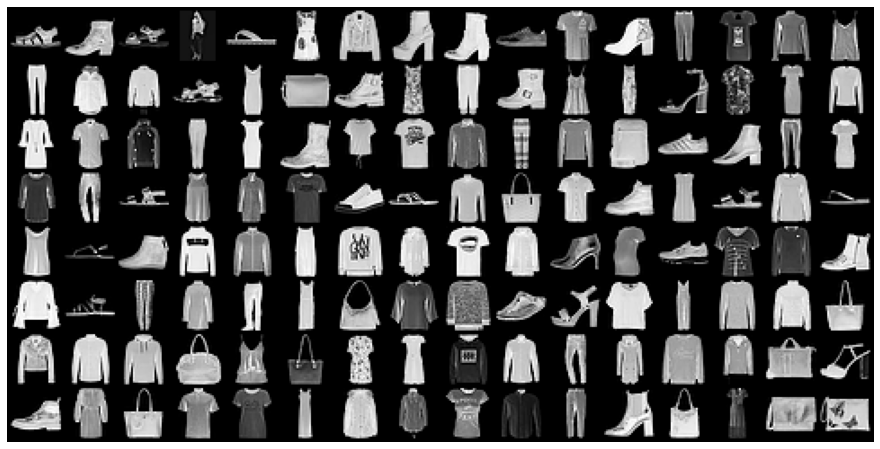

In [8]:
for img, _ in train_loader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(img,nrow=16).permute((1,2,0)))
    break

In [9]:
class FasionMNIST_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, xb):
        xb = xb.reshape(-1, 28*28)
        output = self.linear(xb)
        return output
    
    def training_step(self, batch):
        inputs, labels = batch
        output = self(inputs)
        loss = cross_entropy(output, labels)
        
        return loss
    
    def validation_step(self, batch):
        inputs, labels = batch
        output = self(inputs)
        loss = cross_entropy(output, labels)
#         print("val step : ", output[0])
#         acc, bcc = accuracy(output, labels)
#         return acc, bcc #{"loss": loss.detach(), "acc":acc.detach()}
        
        acc = accuracy(output, labels)
        return {"loss": loss.detach(), "acc":acc.detach()}
    
    def validation_epoch_end(self, result):
        losses = [x['loss'] for x in result]
        val_loss = torch.stack(losses).mean()
        accs = [x['acc'] for x in result]
        val_acc =torch.stack(accs).mean()
        
        return {"loss": val_loss.item(), "acc": val_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("epoch {} => val_loss: {}, accuracy : {}".format(epoch, result['loss'], result['acc']))


In [10]:
def accuracy(pred, target):
    maxval, label = torch.max(pred, dim=1)
    acc_t = torch.tensor(torch.sum(label == target).item()/len(label))
#     print("maxval : ", round(maxval[0].item(),2), label[0].item(), target[0].item(), len(label), acc_t.item()*100)

#         return label, target
    return acc_t
    
def evaluate(model, val_loader):
    val_result = [model.validation_step(batch) for batch in val_loader]   
    return model.validation_epoch_end(val_result)

In [11]:
model = FasionMNIST_Model()
evaluate(model, val_loader)

{'loss': 2.3019092082977295, 'acc': 0.14716796576976776}

In [12]:
def fit(model, epochs, train_loader, test_loader, optim, lr):
    optim = optim(model.parameters(), lr)
    history = []
    
    for epoch in range(epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optim.step()
            optim.zero_grad()
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [13]:
history = fit(model, 20, train_loader, test_loader, SGD, lr)

epoch 0 => val_loss: 2.24224591255188, accuracy : 0.21533203125
epoch 1 => val_loss: 2.1914777755737305, accuracy : 0.2916015684604645
epoch 2 => val_loss: 2.1468794345855713, accuracy : 0.349609375
epoch 3 => val_loss: 2.106719493865967, accuracy : 0.3788085877895355
epoch 4 => val_loss: 2.0698275566101074, accuracy : 0.40234375
epoch 5 => val_loss: 2.0354483127593994, accuracy : 0.4286132752895355
epoch 6 => val_loss: 2.003068685531616, accuracy : 0.453125
epoch 7 => val_loss: 1.9723516702651978, accuracy : 0.47119140625
epoch 8 => val_loss: 1.9430822134017944, accuracy : 0.4869140684604645
epoch 9 => val_loss: 1.9150844812393188, accuracy : 0.501269519329071
epoch 10 => val_loss: 1.8882434368133545, accuracy : 0.5184570550918579
epoch 11 => val_loss: 1.8624598979949951, accuracy : 0.5331054925918579
epoch 12 => val_loss: 1.8376706838607788, accuracy : 0.5477539300918579
epoch 13 => val_loss: 1.8138099908828735, accuracy : 0.5614258050918579
epoch 14 => val_loss: 1.7908308506011963, 

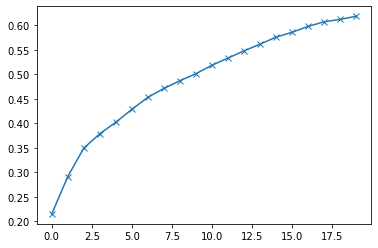

In [14]:
accs = [x['acc'] for x in history]
plt.plot(accs, '-x')
plt.show()

In [15]:
def predict(model, img):
    xb = img.unsqueeze(0)
    yb = model(xb)
    maxvalue,pred = torch.max(yb, dim=1)
    return pred[0].item()

Target : 9 , Prediction : 9


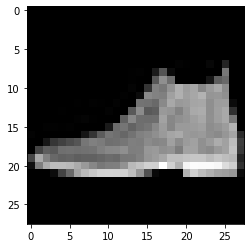

In [16]:
img, labl = testset[0]
print("Target :", testset[0][1], ", Prediction :", predict(model, img))

plt.imshow(test_ds[0][0], cmap='gray')
plt.show()

Target : 4 , Prediction : 4


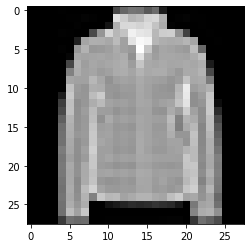

In [17]:
img, label = testset[109]
print("Target :", label, ", Prediction :", predict(model, img))

plt.imshow(test_ds[109][0], cmap='gray')
plt.show()

## Model Scores

In [18]:
evaluate(model, train_loader)

{'loss': 1.6880483627319336, 'acc': 0.6180746555328369}

In [19]:
evaluate(model, val_loader)

{'loss': 1.6875159740447998, 'acc': 0.618359386920929}

In [20]:
evaluate(model, test_loader)

{'loss': 1.6925365924835205, 'acc': 0.6107422113418579}

1. Accuracy of the model on validation dataset : 62.83%
2. test dataset : 61.07%